## WoEEncoder (weight of evidence)

This encoder replaces the labels by the weight of evidence 
#### It only works for binary classification.

The weight of evidence is given by: log( p(1) / p(0) )

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from feature_engine.encoding import WoEEncoder

from feature_engine.encoding import RareLabelEncoder #to reduce cardinality

In [2]:
# Load titanic dataset from file

def load_titanic(filepath='titanic.csv'):
    # data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = pd.read_csv(filepath)
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['age'] = data['age'].astype('float').fillna(data.age.median())
    data['fare'] = data['fare'].astype('float').fillna(data.fare.median())
    data['embarked'].fillna('C', inplace=True)
    # data.drop(labels=['boat', 'body', 'home.dest', 'name', 'ticket'], axis=1, inplace=True)
    return data

In [3]:
# data = load_titanic("../data/titanic.csv")
data = load_titanic("../data/titanic-2/Titanic-Dataset.csv")
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,n,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,n,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,n,S


In [4]:
X = data.drop(['survived', 'name', 'ticket'], axis=1)
y = data.survived

In [5]:
# we will encode the below variables, they have no missing values
X[['cabin', 'pclass', 'embarked']].isnull().sum()

cabin       0
pclass      0
embarked    0
dtype: int64

In [6]:
''' Make sure that the variables are type (object).
if not, cast it as object , otherwise the transformer will either send an error (if we pass it as argument) 
or not pick it up (if we leave variables=None). '''

X[['cabin', 'pclass', 'embarked']].dtypes

cabin       object
pclass      object
embarked    object
dtype: object

In [7]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((623, 9), (268, 9))

In [8]:
## Rare value encoder first to reduce the cardinality
# see RareLabelEncoder jupyter notebook for more details on this encoder
rare_encoder = RareLabelEncoder(tol=0.03,
                                n_categories=2, 
                                variables=['cabin', 'pclass', 'embarked'])

rare_encoder.fit(X_train)

# transform
train_t = rare_encoder.transform(X_train)
test_t = rare_encoder.transform(X_test)

The WoERatioEncoder() replaces categories by the weight of evidence
or by the ratio between the probability of the target = 1 and the probability
of the  target = 0.

The weight of evidence is given by: log(P(X=x<sub>j</sub>|Y = 1)/P(X=x<sub>j</sub>|Y=0))


Note: This categorical encoding is exclusive for binary classification.

For example in the variable colour, if the mean of the target = 1 for blue
is 0.8 and the mean of the target = 0  is 0.2, blue will be replaced by:
np.log(0.8/0.2) = 1.386
#### Note: 
The division by 0 is not defined and the log(0) is not defined.
Thus, if p(0) = 0 or p(1) = 0 for
woe , in any of the variables, the encoder will return an error.
   
The encoder will encode only categorical variables (type 'object'). A list
of variables can be passed as an argument. If no variables are passed as 
argument, the encoder will find and encode all categorical variables
(object type).<br>

For details on the calculation of the weight of evidence visit:<br>
https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

### Weight of evidence

In [9]:
woe_enc = WoEEncoder(variables=['cabin', 'pclass', 'embarked'])

# to fit you need to pass the target y
woe_enc.fit(train_t, y_train)

WoEEncoder(variables=['cabin', 'pclass', 'embarked'])

In [10]:
woe_enc.encoder_dict_

{'cabin': {'B': 1.686005330262647,
  'C': 0.7415437214217956,
  'D': 1.2647918651863435,
  'E': 1.5036837734686923,
  'Rare': 0.4538616489700146,
  'n': -0.3763073291542219},
 'pclass': {1: 0.9510351835676779,
  2: 0.3932370271535797,
  3: -0.6890234633760831},
 'embarked': {'C': 0.7468487736514886,
  'Q': 0.09284830343268406,
  'S': -0.20339260852932417}}

In [11]:
# transform and visualise the data

train_t = woe_enc.transform(train_t)
test_t = woe_enc.transform(test_t)

test_t.sample(5)

,passengerid,pclass,sex,age,sibsp,parch,fare,cabin,embarked
145,146,0.393237,male,19.0,1,1,36.7500,-0.376307,-0.203393
768,769,-0.689023,male,28.0,1,0,24.1500,-0.376307,0.092848
726,727,0.393237,female,30.0,3,0,21.0000,-0.376307,-0.203393
778,779,-0.689023,male,28.0,0,0,7.7375,-0.376307,0.092848
122,123,0.393237,male,32.5,1,0,30.0708,-0.376307,0.746849


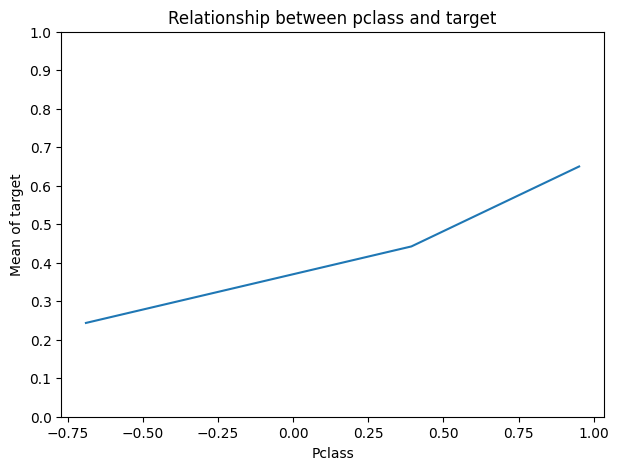

In [12]:
''' The WoEEncoder has the characteristic that return monotonic
 variables, that is, encoded variables which values increase as the target increases'''

# let's explore the monotonic relationship
plt.figure(figsize=(7,5))
pd.concat([test_t,y_test], axis=1).groupby("pclass")["survived"].mean().plot()
#plt.xticks([0,1,2])
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Relationship between pclass and target")
plt.xlabel("Pclass")
plt.ylabel("Mean of target")
plt.show()

### Automatically select the variables

This encoder will select all categorical variables to encode, when no variables are specified when calling the encoder.

In [13]:
ratio_enc = WoEEncoder()

# to fit we need to pass the target y
ratio_enc.fit(train_t, y_train)

WoEEncoder()

In [14]:
# transform and visualise the data

train_t = ratio_enc.transform(train_t)
test_t = ratio_enc.transform(test_t)

test_t.head()

,passengerid,pclass,sex,age,sibsp,parch,fare,cabin,embarked
495,496,-0.689023,-0.957125,28.0,0,0,14.4583,-0.376307,0.746849
648,649,-0.689023,-0.957125,28.0,0,0,7.5500,-0.376307,-0.203393
278,279,-0.689023,-0.957125,7.0,4,1,29.1250,-0.376307,0.092848
31,32,0.951035,1.571166,28.0,1,0,146.5208,1.686005,0.746849
255,256,-0.689023,1.571166,29.0,0,2,15.2458,-0.376307,0.746849
